# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Sub categories of buildings in proximity to the sensor:
        * Average number of floors of buildings in vicinity
        * Building type - Community use/Education/Entertainment/Events/Hospital or clinic/Office/Parking/Public display area/Residential/Retail/Storage/Transport/Unoccupied/Working
    * Sub categories of landmarks in proximity to the sensor:   
        * Landmark type - Community use/Health services/Leisure or recreation/Mixed use/Office/Place of Assembly/Place of Worship/Retail/ Transport
    * Sub categories of furniture in proximity to the sensor:    
        * Barbeque/Bicycle Rails/Bollard/Drinking fountaion/Crate or planter box/Hoop/Horse trough/Information pillar/Litter bin/Picnic setting/Seat/Tree guard
    * Lights

<u> Thoughts </u>  
Why are so many of the bulding/furniture categories correlated? Are most of the buldings all close together? plot to check.

Landmarks - the maximum number of features is 5 across all the sensors, but many have only 1 or 0. Definitely doesn't seem to make sense to include the subtypes. However, landmakes_transport does seem quite relevant


Normalise variables: should this be with MinMax or StandardScaler??

### Error metrics
MAE=10 implies that, on average, the forecast's distance from the true value is 10 (e.g true value is 200 and forecast is 190 or true value is 200 and forecast is 210 would be a distance of 10). 

MAPE=10 implies that, on average, the forecast's distance from the true value is 10% of the true value (e.g true value is 100 and forecast is 90 or true value is 100 and forecast is 110 would be a distance of 10%).

In [1]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from xgboost import XGBClassifier, XGBRegressor
import datashader as ds
from datashader.mpl_ext import dsshow
from scipy import stats
import math

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from Functions import *

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
def using_datashader(ax, x, y):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(df,ds.Point("x", "y"),ds.count(), vmin=0.1, vmax=100,norm="linear",aspect="auto",ax=ax)
    plt.colorbar(dsartist)

### Read in formatted data

In [2]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Keep only sensors with relatively complete data

In [3]:
### Filter to include just sensors which we know have quite complete data 
data = data[data['sensor_id'].isin([2,6,9,10,14,18])]
data.reset_index(inplace=True, drop = True)

In [8]:
# data = data.drop(['Pressure', 'Humidity'],axis=1) # seem obviously irrelevant
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

In [ ]:
def run_model_with_cv(model,model_name, metrics, cv, Xfull, Yfull):
    
    # Filter columns
    Xfull = Xfull[Xfull.columns.drop(list(Xfull.filter(regex=regex_pattern)))]
    Xfull['random'] = np.random.random(size=len(Xfull))
    
    start = time()
    scores = cross_validate(model, Xfull, Yfull, cv=cv, scoring=metrics ,return_estimator=False, error_score="raise")

    mae_scores = scores['test_neg_mean_absolute_error']
    r2_scores = scores['test_r2']
    rmse_scores = scores['test_neg_root_mean_squared_error']
    df =pd.DataFrame({'mae': round(abs(mae_scores.mean()),2), 'r2': round(abs(r2_scores.mean()),2),
              'rmse': round(abs(rmse_scores.mean()),2)}, index =[model_name])
    end = time()
    result = end - start
    print('Ran in {} minutes'.format(round(result/60),2))
    return [mae_scores, r2_scores, rmse_scores, df]


df_nosubtypes = 'buildings_|furniture_|landmarks_|sensor_id'
df_justlocationfeatures = 'buildings$|furniture$|landmarks$|school_holiday|public_holiday|Temp|Humidity|Pressure|Rain|WindSpeed|Sin|Cos'
df_time_and_weather = 'buildings|furniture|landmarks|h_|lights|avg_n_floors|betweenness'
df_subtypes = 'buildings$|furniture$|landmarks$'

## Prepare data for modelling - split into predictor/predictand variables

In [59]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)

# The variable to be predicted
Yfull = data['hourly_counts'].values

# Split data into training and test sets
# stratify=y. This tells train_test_split to make sure that the training and test datasets contain examples of 
# each class in the same proportions as in the original dataset
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.8, random_state=123)

#### Standardize both training and testing data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 
feature_list = list(Xfull.columns)

## Modelling - naive predictive model

## Modelling - Linear regression

### Fit model

In [16]:
#### Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

### Print results
print('Training score: ', lr_model.score(X_train, Y_train))
print('Test score: ', lr_model.score(X_test, Y_test))
print('CV score: ', (cross_val_score(lr_model, X_train, Y_train)).mean())

Training score:  0.4771189861724787
Test score:  0.47927435186667766
CV score:  0.476701322270695


### Use fitted model to make predictions on the unseen data

In [17]:
# Make predictions on the testing data
lr_predictions = lr_model.predict(X_test)
lr_residuals = Y_test - lr_predictions

### Evaluate model performance by comparing to actual values

In [18]:
# Calculate the absolute errors
abs_errors = abs(lr_predictions - Y_test)
# Mean absolute percentage errors
mape = mean_absolute_percentage_error(Y_test, lr_predictions)
# Mean absolute error
mae = round(np.mean(abs_errors), 2)
# Calculate r2 value (well, just_rvalue, its squared in the print statement)
m, b, r_value, p_value, std_err = stats.linregress(lr_predictions, Y_test)
# RMSE
MSE = np.square(np.subtract(lr_predictions,Y_test)).mean() 
RMSE = math.sqrt(MSE)

# Add to Dataframe
accuracy_results_lr = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['LinearRegression'])

### Evaluate the suggested feature importances

In [19]:
# Collect the model coefficients in a dataframe
lr_df_coef = pd.DataFrame(lr_model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
lr_df_coef['coef_abs'] = lr_df_coef.coefficients.abs()

lr_feature_importance= lr_df_coef.sort_values(by = 'coefficients', ascending = False)
lr_feature_importance.reset_index(inplace = True)

### Plot

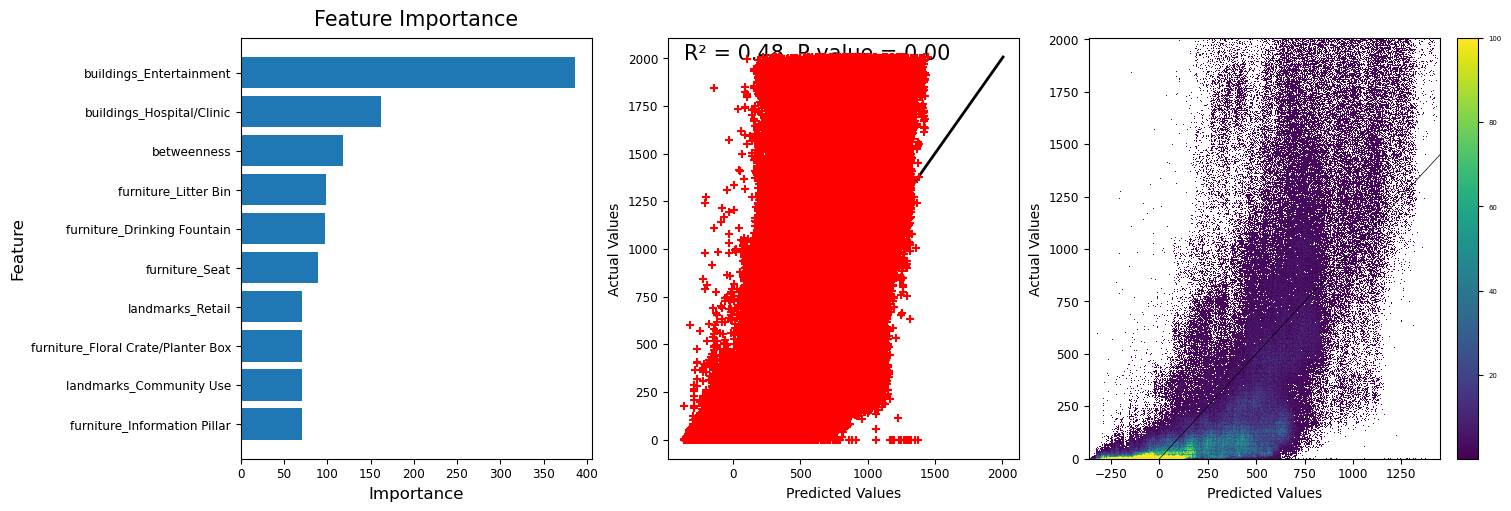

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(lr_feature_importance['index'][:10], lr_feature_importance['coefficients'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(lr_predictions, Y_test, s=30, c='r', marker='+', zorder=10)
m, b, r_value, p_value, std_err = stats.linregress(lr_predictions, Y_test)
axs[1].annotate('R\N{SUPERSCRIPT TWO} = ' + str("{:.2f}".format(r_value**2))
                    + ', P value = ' + str("{:.2f}".format(p_value**2)) , 
                     xy=(lr_predictions.min() + (lr_predictions.min()/150), Y_test.max() - (Y_test.max()/150)),
                   color = 'black', size = 15)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], lr_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

## Modelling - Random forest regressor

### Fit model

In [23]:
# Instantiate model with 1000 decision trees
rf_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_model.fit(X_train, Y_train);

### Use fitted model to make predictions on the unseen data

In [24]:
rf_predictions = rf_model.predict(X_test)

### Evaluate model performance by comparing to actual values

In [25]:
# Calculate the absolute errors
abs_errors = abs(rf_predictions - Y_test)
# Mean absolute percentage errors
mape = mean_absolute_percentage_error(Y_test, rf_predictions)
# Mean absolute error
mae = round(np.mean(abs_errors), 2)
# Calculate r2 value (well, just_rvalue, its squared in the print statement)
m, b, r_value, p_value, std_err = stats.linregress(rf_predictions, Y_test)
# RMSE
MSE = np.square(np.subtract(rf_predictions,Y_test)).mean() 
RMSE = math.sqrt(MSE)

# Add to Dataframe
accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['RandomForest'])

### Plot one decision tree from the random forest

In [24]:
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

In [25]:
# # Limit depth of tree to 3 levels
# rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
# rf_small.fit(X_train, Y_train)
# # Extract the small tree
# tree_small = rf_small.estimators_[5]
# # Save the tree as a png image
# export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
# graph.write_png('tree.png')

### Evaluate the suggested feature importances

In [27]:
# Get numerical feature importances
rf_importances = list(rf_model.feature_importances_)
rf_feature_importances = pd.DataFrame({'feature': feature_list,'importance':rf_importances})      
rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = False)

In [ ]:
from sklearn.inspection import permutation_importance
# r = permutation_importance(rf_model, X_train, Y_train, n_repeats=10,random_state=0, n_jobs=64)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_model, random_state=1).fit(X_test, Y_test)
eli5.show_weights(perm, feature_names = val_x.columns.tolist())

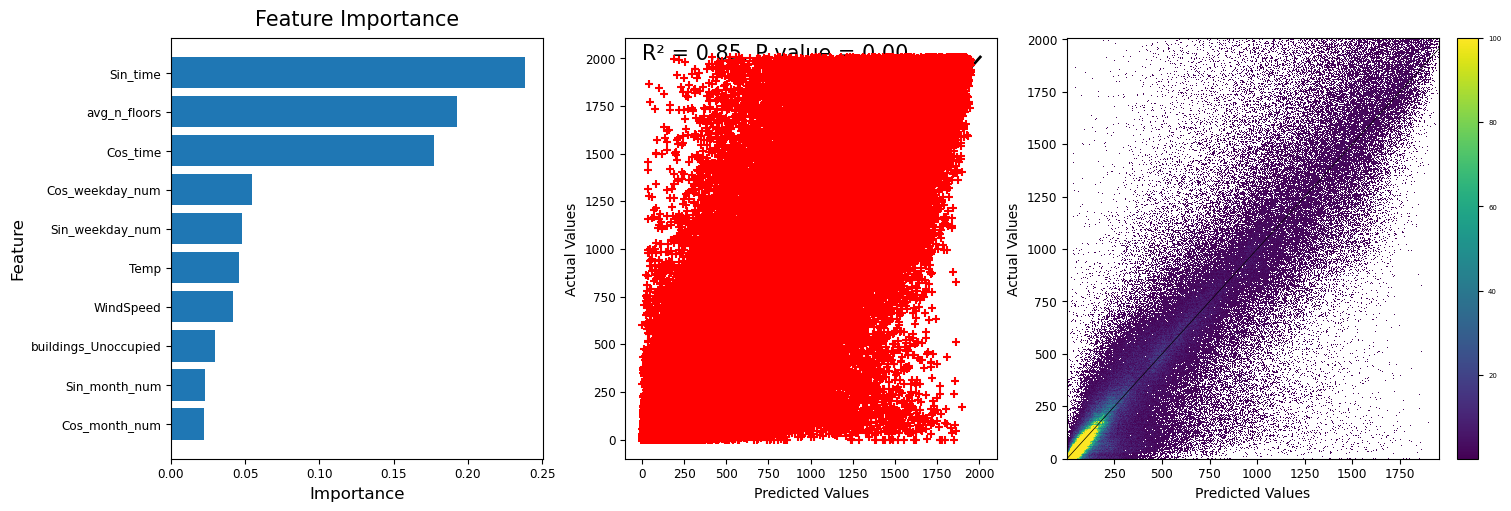

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(rf_predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].annotate('R\N{SUPERSCRIPT TWO} = ' + str("{:.2f}".format(r_value**2))
                    + ', P value = ' + str("{:.2f}".format(p_value**2)) , 
                     xy=(rf_predictions.min() + (rf_predictions.min()/150), Y_test.max() - (Y_test.max()/150)),
                   color = 'black', size = 15)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], rf_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

## XGBOOST

### Fit model

In [29]:
xgb_model = XGBRegressor(n_jobs = 100)
xgb_model.fit(X_train, Y_train);

### Use fitted model to make predictions on the unseen data

In [30]:
y_pred = xgb_model.predict(X_test)
xgb_predictions = [round(value) for value in y_pred]

### Evaluate model performance by comparing to actual values

In [31]:
# Calculate the absolute errors
abs_errors = abs(xgb_predictions - Y_test)
# Mean absolute percentage errors
mape = mean_absolute_percentage_error(Y_test, xgb_predictions)
# Mean absolute error
mae = round(np.mean(abs_errors), 2)
# Calculate r2 value (well, just_rvalue, its squared in the print statement)
m, b, r_value, p_value, std_err = stats.linregress(xgb_predictions, Y_test)
# RMSE
MSE = np.square(np.subtract(xgb_predictions,Y_test)).mean() 
RMSE = math.sqrt(MSE)

# Add to Dataframe
accuracy_results_xgb= pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['XGBoost'])

### Evaluate the suggested feature importances

In [32]:
xgb_importances = list(xgb_model.feature_importances_)
xgb_feature_importances = pd.DataFrame({'feature': feature_list,'importance':xgb_importances})      
xgb_feature_importances= xgb_feature_importances.sort_values(by = 'importance', ascending = False)

### Plot 

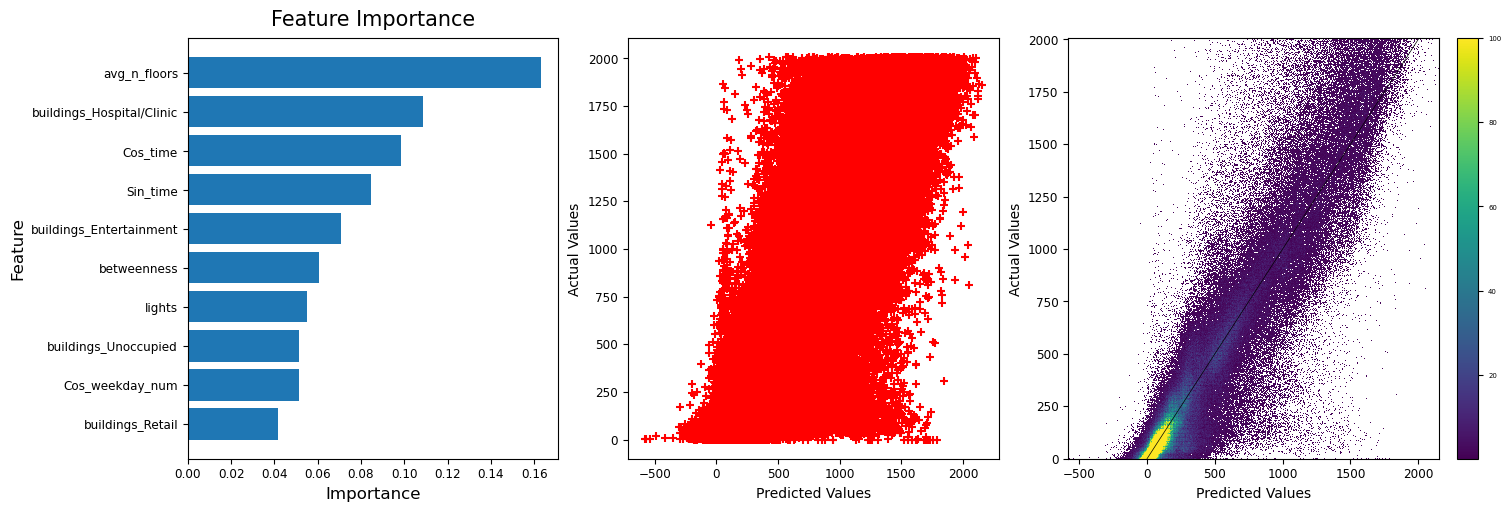

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(xgb_feature_importances['feature'][:10], xgb_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

axs[1].scatter(xgb_predictions, Y_test, s=30, c='r', marker='+', zorder=10)
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
axs[1].set_xlabel("Predicted Values", size=10)
axs[1].set_ylabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], xgb_predictions, Y_test)
axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_xlabel("Predicted Values", size=10)
axs[2].set_ylabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()

### Compare the accuracies from the 3 models

In [81]:
pd.concat([accuracy_results_lr, accuracy_results_rf, accuracy_results_xgb])

,MAPE,MAE,RMSE,R2
LinearRegression,9.221024e+15,260.22,354.666813,0.479303
RandomForest,1.176729e+15,99.86,191.014054,0.849071
XGBoost,1.548362e+15,105.07,186.524768,0.856059


### Find the best model  
Use k-fold cross validation to evaluate a range of regression algorithms on the training data. Use a pipeline for evaluation which first scales the (weather) data. Print the results and assess which models perform best.

The following models were trialled:

* Decision Tree
* Random Forest
* Extra Trees
* Dummy Regressor
* Elastic Net CV
* Passive Aggressive
* RANSAC
* SGD
* TheilSen (dropped in code below because it takes too long)
* K Neighbours
* LinearRegression
* XGBoost

In [84]:
import multiprocessing
from multiprocessing import Pool # To run models in multiple threads simultaneously
import time as thetime
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

# Define a list of all the models to use
Models = {'LinearRegression': LinearRegression,#'DecisionTree' : DecisionTreeRegressor,
          'RandomForest': RandomForestRegressor,# 'ExtraTrees' : ExtraTreesRegressor,
#           'DummyRegressor' :DummyRegressor, 'ElasticNetCV' : ElasticNetCV, 
#           'PassiveAggressive' : PassiveAggressiveRegressor, #RANSAC': RANSACRegressor, # This one is terrible too
#           'SGD': SGDRegressor, #'TheilSen': TheilSenRegressor, # Drop this - it isn't great and takes too long
#           'KN': KNeighborsRegressor}
            'XGBoost': XGBRegressor}
 
# Now just run each model, but do this in multiple processes simultaneously to save time    
# Now call that function simultaneously for each model
p = Pool(processes=None) # A pool of processes (one for each core)
results = p.map(run_model, [(name, model_type) for name, model_type in Models.items()])

# Sort the results by median mse (that's item 5 in the tuple)
results.sort(key=lambda x: x[5], reverse=True)

# Put the results in a nice dictionary and print them
results_dict = {}
txt = "<table><thead><td>Name</td><td>Median R2</td><td>Median MSE</td><td>runtime (sec)</td></thead>"
for name, model, all_r2, r2, all_mse, mse, runtime in results:
    txt += "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(name, r2, mse, runtime)
    results_dict[name] = (model, all_r2, r2, all_mse, mse, runtime)
txt += "</table>"
display(HTML(txt)) # print as html

min_mse = min([mse for (name, model, all_r2, r2, all_mse, mse, runtime) in results])
               
x =  [ name for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y1 = [ mse-min_mse   for (name, model, all_r2, r2, all_mse, mse, runtime) in results]
y2 = [ r2 if r2 > 0 else 0 for (name, model, all_r2, r2, all_mse, mse, runtime) in results]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.set_title("MSE")
#ax1.invert_yaxis()
ax1.bar(range(len(x)), y1)
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=90)
ax1.set_ylim([27000000000, 29000000000])

ax2.set_title("R^2")
ax2.bar(range(len(x)), y2)
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x, rotation=90)

plt.show()

#del x,y1, y2

## Set up a dictionary containing the hyperparameters we want to tune
hyperparameters_rf = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
# hyperparameters_xgb = {'xgbregressor__max_depth': range(1, 11, 2),
#                    'xgbregressor__n_estimators' : range(50, 400, 50),
#                    'xgbregressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
hyperparameters_lr = {}

# Set up the pipeline containing the scalers
pipeline_rf = make_pipeline(MinMaxScaler(feature_range = (0,1)), 
                         RandomForestRegressor(n_estimators=100))
# pipeline_xgb = make_pipeline(MinMaxScaler(feature_range = (0,1)),
#                          xgb.XGBRegressor(n_estimators=100))
pipeline_lr = make_pipeline(MinMaxScaler(feature_range = (0,1)),
                         LinearRegression())

# Store the scores in a results dictionary (and print them)
final_results = {}
for model_values in [(pipeline_rf,  hyperparameters_rf,  'RandomForest'),
#                      (pipeline_xgb, hyperparameters_xgb, 'XGBoost'),
                     (pipeline_lr,  hyperparameters_lr,  'LinearRegression')]:
    
    clf = GridSearchCV(model_values[0], model_values[1], 
                       #cv = None, # Cross-validation method. None means default (3-fold)
                       cv = 10, # positive intiger means k-fold (e.g. 10-fold)
                       #scoring  = 'neg_mean_squared_error', # MSE to calculate score
                       scoring  = 'r2', # MSE to calculate score
                       n_jobs=multiprocessing.cpu_count()) # Run on multiple cores
    
    #clf = GridSearchCV(model_values[0], model_values[1], cv = 10, scoring  = 'r2')
    clf.fit(X_validate, Y_validate)
    name = model_values[2]
    final_results[name] = clf
    print ("Hyperparameter results for {}".format(name))
    print ("\tBest Score: {}".format(clf.best_score_))
    print ("\tBest params: {}".format(clf.best_params_))

Process ForkPoolWorker-170:
Process ForkPoolWorker-192:
Process ForkPoolWorker-182:
Process ForkPoolWorker-186:
Process ForkPoolWorker-177:
Process ForkPoolWorker-183:
Process ForkPoolWorker-180:
Process ForkPoolWorker-165:
Process ForkPoolWorker-175:
Process ForkPoolWorker-191:
Process ForkPoolWorker-167:
Process ForkPoolWorker-179:
Process ForkPoolWorker-190:
Process ForkPoolWorker-187:
Process ForkPoolWorker-185:
Process ForkPoolWorker-164:
Process ForkPoolWorker-176:
Process ForkPoolWorker-169:
Process ForkPoolWorker-181:
Process ForkPoolWorker-168:
Process ForkPoolWorker-178:
Process ForkPoolWorker-173:
Process ForkPoolWorker-184:
Process ForkPoolWorker-189:
Process ForkPoolWorker-188:
Process ForkPoolWorker-171:
Process ForkPoolWorker-174:
Process ForkPoolWorker-166:
Process ForkPoolWorker-172:
Process ForkPoolWorker-162:
Traceback (most recent call last):
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 297, in

KeyboardInterrupt: 

  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in 

  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/footfall_ml/lib/python3.7/multip